In [15]:
pip install graphviz

In [16]:
pip install pydot

In [17]:
pip install metrics

In [1]:
from __future__ import print_function
import numpy as np
import h5py
import glob
import math
import os
import shutil
from keras.utils import plot_model

from scipy import signal
from scipy.signal import butter, lfilter
from scipy.optimize import linear_sum_assignment
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,
    Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape,
    Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose, InputSpec, Layer
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')


In [2]:
x = np.load('/content/x.np.npy')


In [3]:
y = np.load('/content/y.np.npy')

In [4]:
print(y[700:710])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
print(x.shape)
print(y.shape)


(9200, 16, 48, 1)
(9200,)


In [6]:
x.dtype

dtype('float64')

In [7]:
n_clusters = 2

Building the AutoEncoder

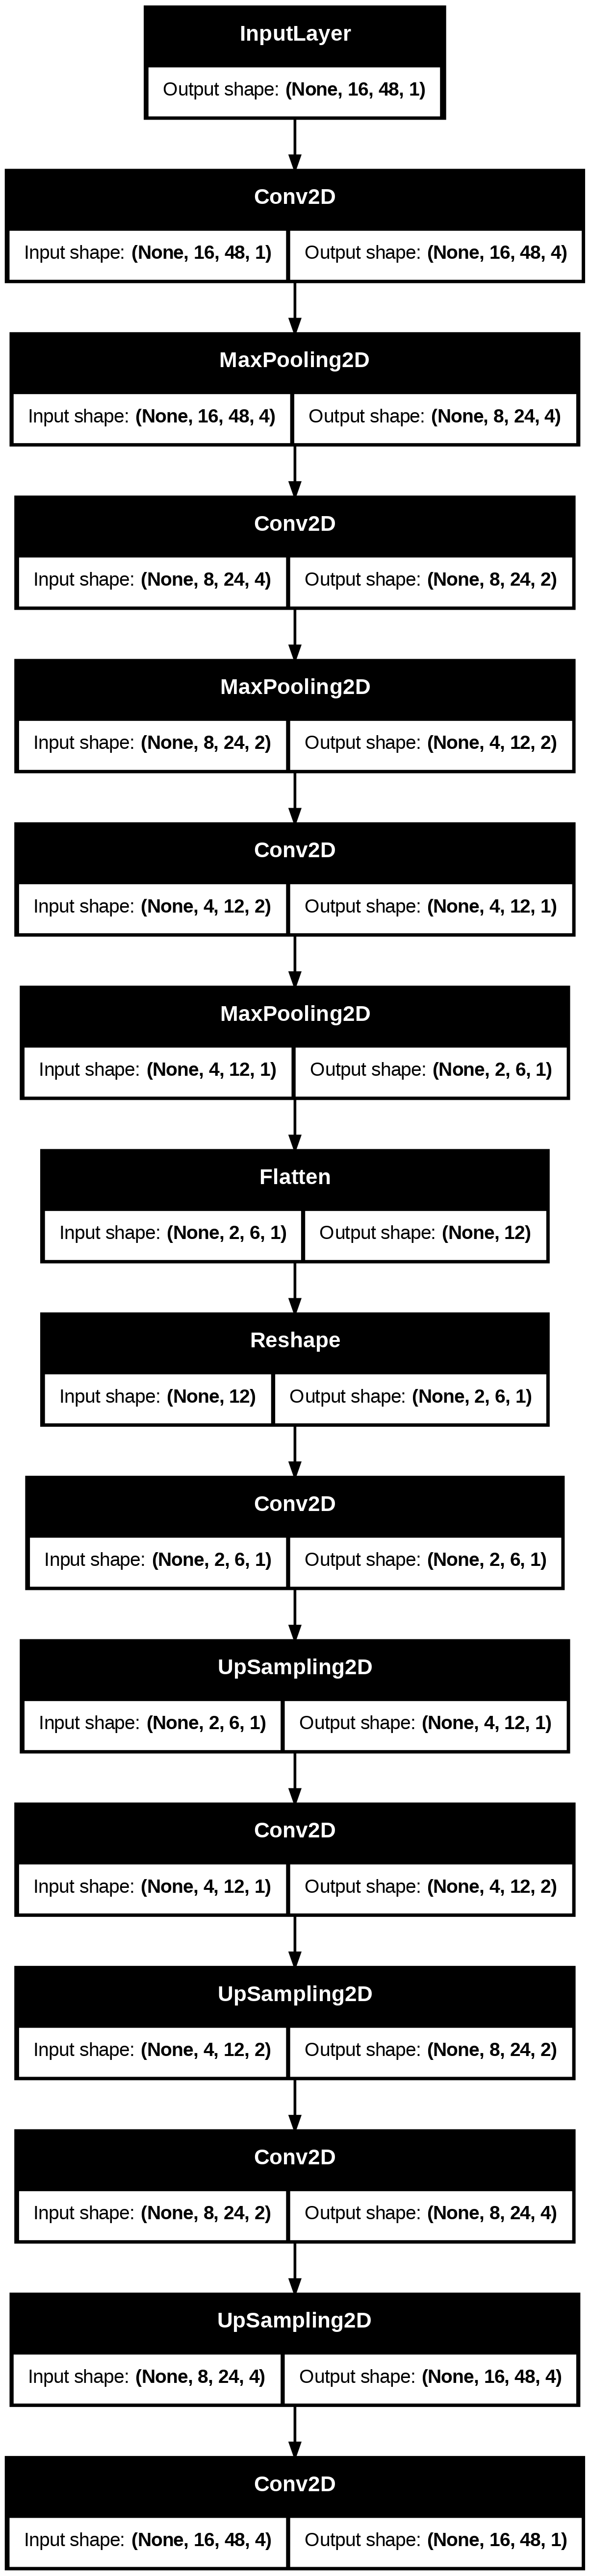

In [8]:
inp = Input(shape=(16, 48, 1))
e = Conv2D(4, (3, 3), activation='tanh', padding='same')(inp)
e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(2, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(1, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 2), padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv2D(1, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(2, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(4, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')
#autoencoder.summary()

from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

In [25]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [9]:
autoencoder.compile(optimizer='adam', loss='mse')
csv_logger = CSVLogger('pretrain_log.csv')

autoencoder.fit(x, x, batch_size=128, epochs=50, callbacks=[csv_logger])

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0108
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0071
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0064
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0057
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0049
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0046
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0044
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0043
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0042
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0041
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0041
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0039
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0039
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0039
Epoch 15/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0038
Epoc

...Finetuning...


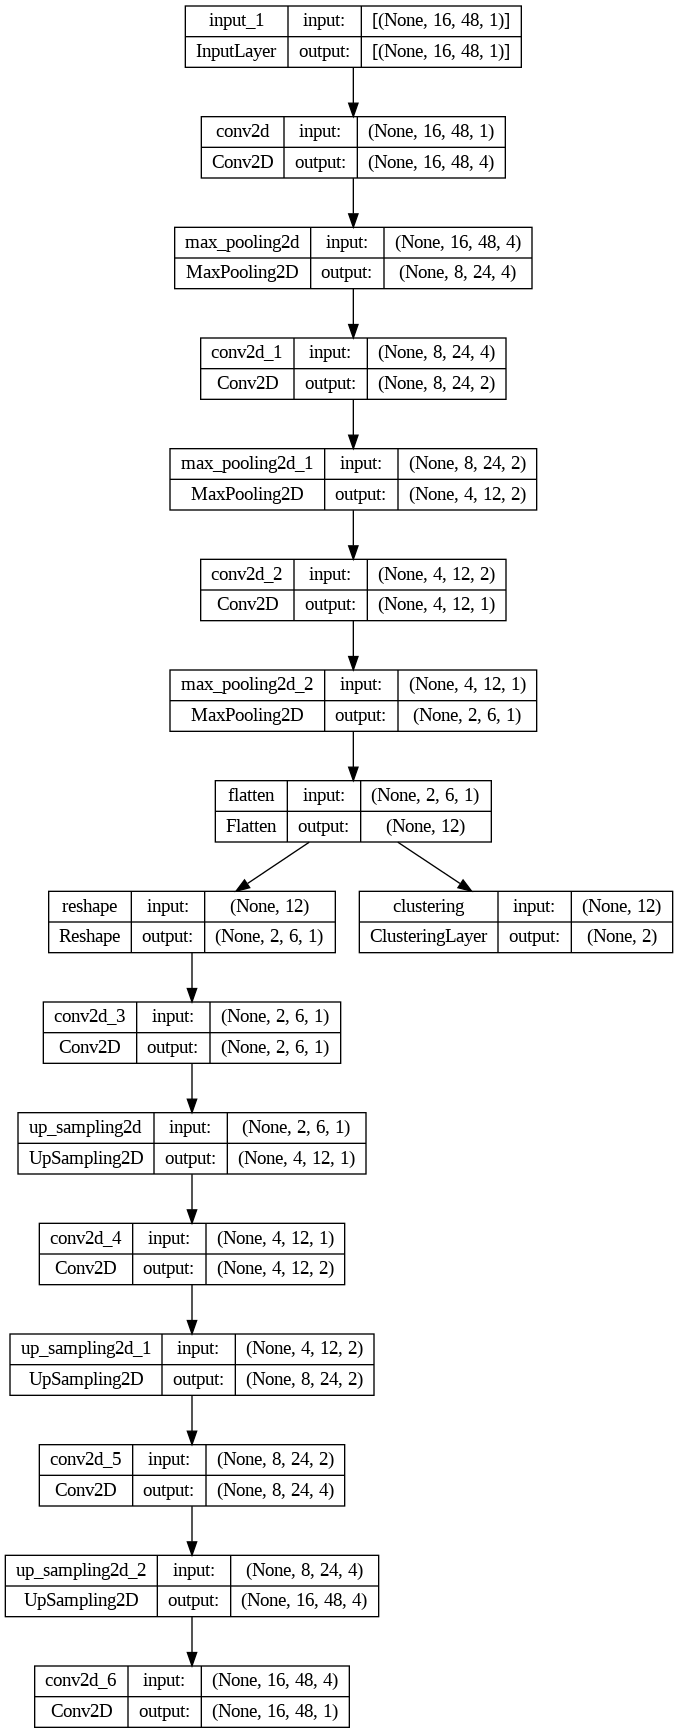

In [ ]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        # Ensure 'self' is used within the class method
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))

        # Ensure 'name' is passed correctly
        self.clusters = self.add_weight(
            name='clusters',  # 'name' should be specified explicitly here
            shape=(self.n_clusters, input_dim),
            initializer='glorot_uniform'
        )

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
print('...Finetuning...')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')


In [ ]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment  # Replaces sklearn.utils.linear_assignment_

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed.

    # Arguments
        y_true: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    # Use linear_sum_assignment from scipy instead of sklearn.utils.linear_assignment_
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size


# Initializing the weights using KMeans and assigning them to the model
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

# Use the acc function directly
accuracy = np.round(acc(y, y_pred), 5)
print("Clustering Accuracy:", accuracy)


288/288 [==============================] - 1s 3ms/step
Clustering Accuracy: 0.94065


In [ ]:
import numpy as np

# Assuming acc function is defined as before
from scipy.optimize import linear_sum_assignment
def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed.

    # Arguments
        y_true: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size


# Parameters for finetuning
batch_size = 256
tol = 0.001  # Tolerance threshold to stop training
loss = 0
index = 0
maxiter = 5000
update_interval = 150
index_array = np.arange(x.shape[0])

###############################################################################
### Simultaneous Optimization and Clustering
def target_distribution(q):
    """
    Target distribution for clustering.
    """
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T


for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _ = model.predict(x, verbose=0)
        p = target_distribution(q)  # Update the auxiliary target distribution p
        y_pred = q.argmax(1)  # Evaluate the clustering performance

        if y is not None:
            clustering_acc = np.round(acc(y, y_pred), 5)  # Call acc directly
            loss = np.round(loss, 5)
            print(f'Iter {ite}: acc = {clustering_acc:.5f} ; loss = {loss}')

        # Check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)

        if ite > 0 and delta_label < tol:
            print(f'delta_label {delta_label} < tol {tol}')
            break

        IN = encoder.predict(x)

    # Training on batches
    idx = index_array[index * batch_size: min((index + 1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0


Iter 0: acc = 0.94065 ; loss = 0
288/288 [==============================] - 1s 3ms/step
Iter 150: acc = 0.94239 ; loss = [0.00234 0.      0.00234]
288/288 [==============================] - 1s 3ms/step
Iter 300: acc = 0.94565 ; loss = [0.00218 0.      0.00218]
288/288 [==============================] - 1s 3ms/step
Iter 450: acc = 0.94065 ; loss = [2.21e-03 5.00e-05 2.20e-03]
288/288 [==============================] - 1s 3ms/step
Iter 600: acc = 0.94924 ; loss = [0.00405 0.00012 0.00404]
288/288 [==============================] - 1s 3ms/step
Iter 750: acc = 0.94011 ; loss = [0.00429 0.00036 0.00426]
288/288 [==============================] - 1s 3ms/step
Iter 900: acc = 0.94109 ; loss = [0.0039  0.00111 0.00379]
288/288 [==============================] - 1s 3ms/step
Iter 1050: acc = 0.95043 ; loss = [0.00314 0.00471 0.00267]
288/288 [==============================] - 1s 3ms/step
Iter 1200: acc = 0.96272 ; loss = [0.00496 0.02227 0.00273]
288/288 [==============================] - 1s 3ms/

288/288 [==============================] - 1s 3ms/step


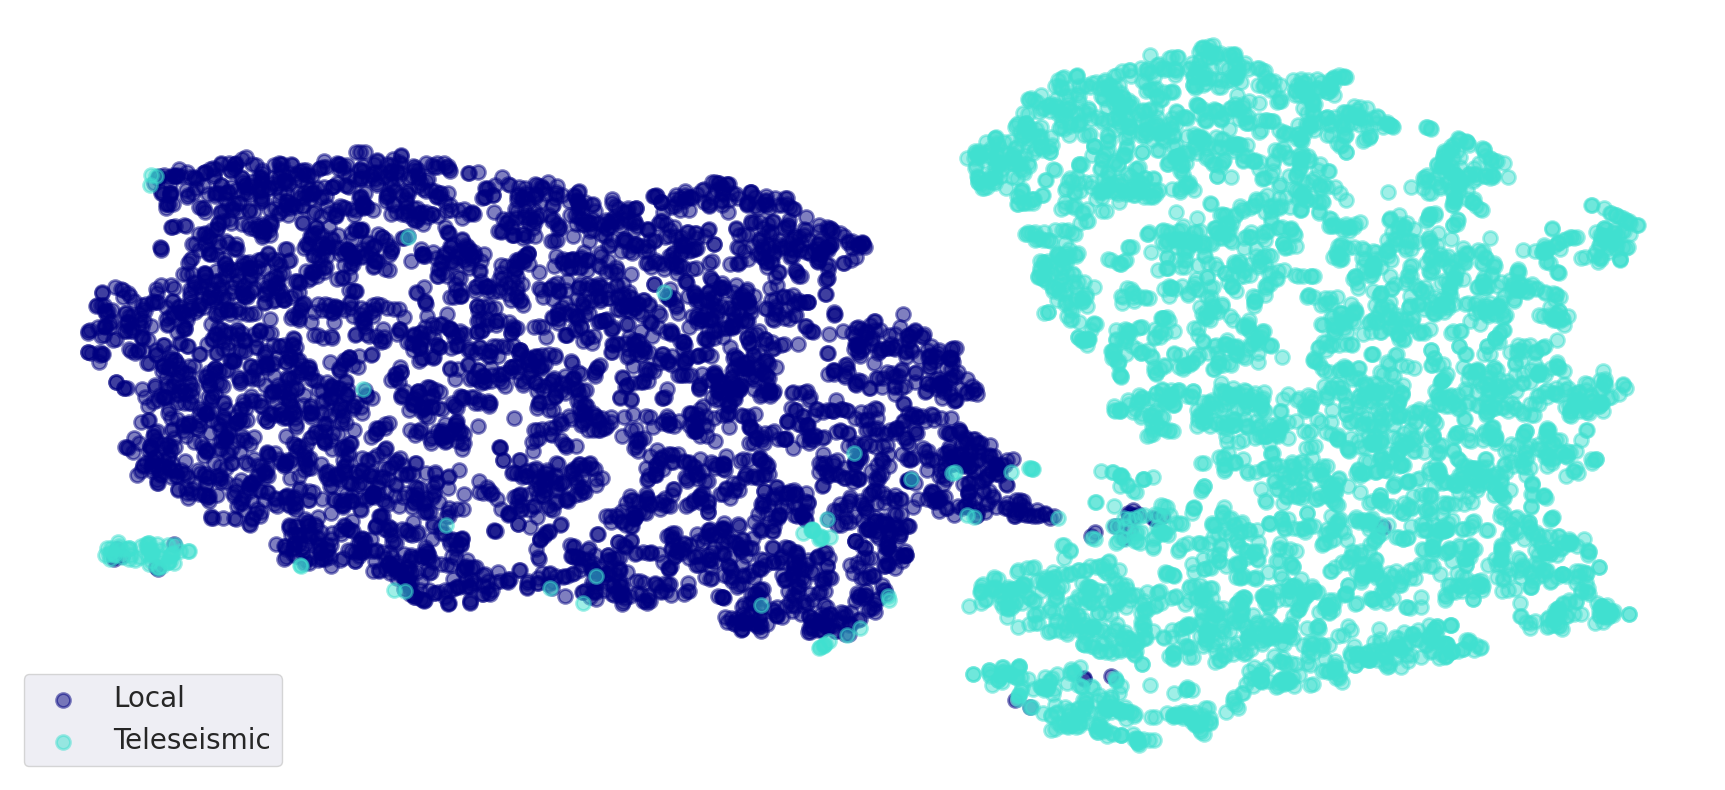

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [ ]:
def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = ['navy', 'turquoise', 'darkorange']
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [0, 1], target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 20})
    ax.axis('off')
    ax.axis('tight')
    plt.show()

    return f, ax

enc = encoder.predict(x)
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
target_names = ['Local', 'Teleseismic']
plotter(redu, y, target_names)


288/288 [==============================] - 1s 3ms/step


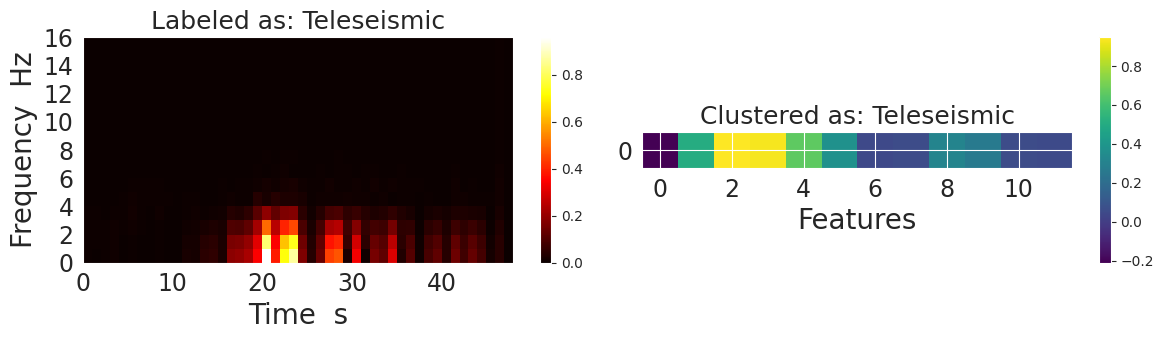

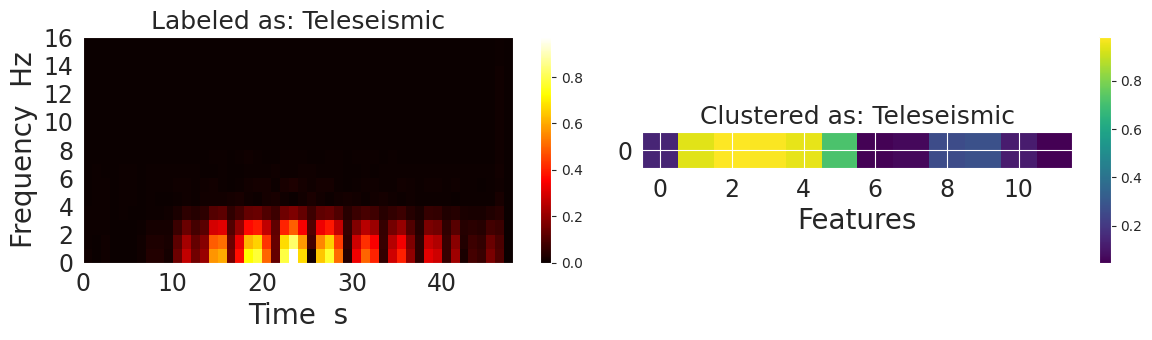

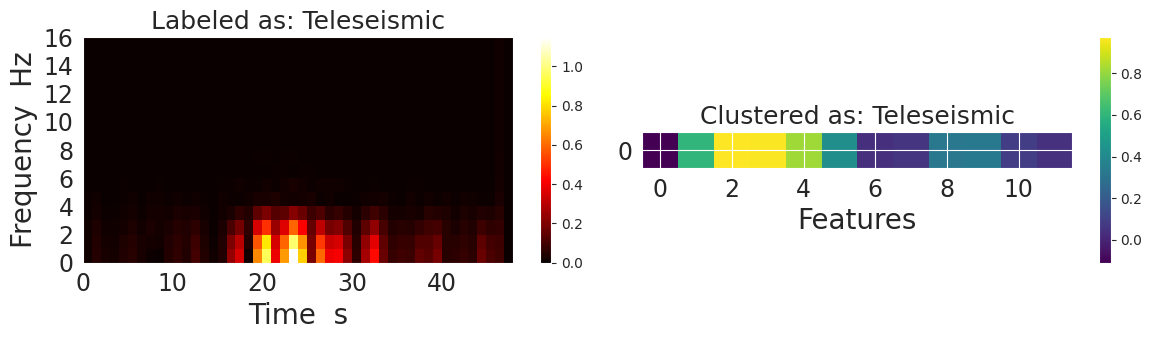

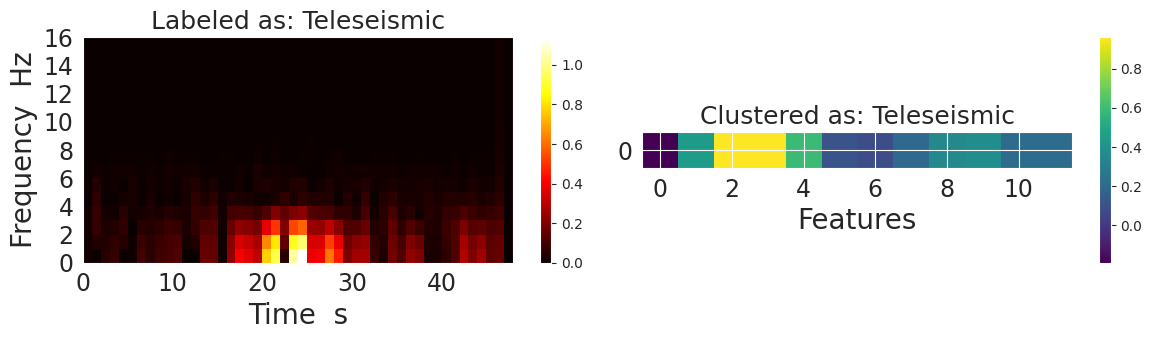

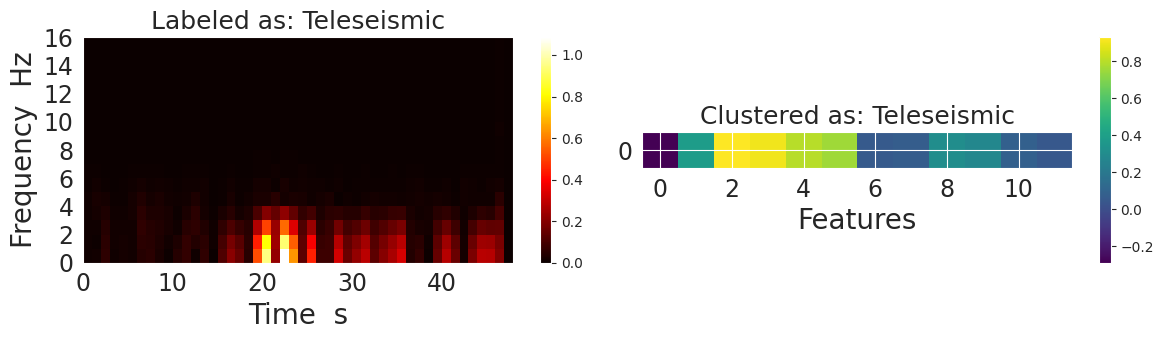

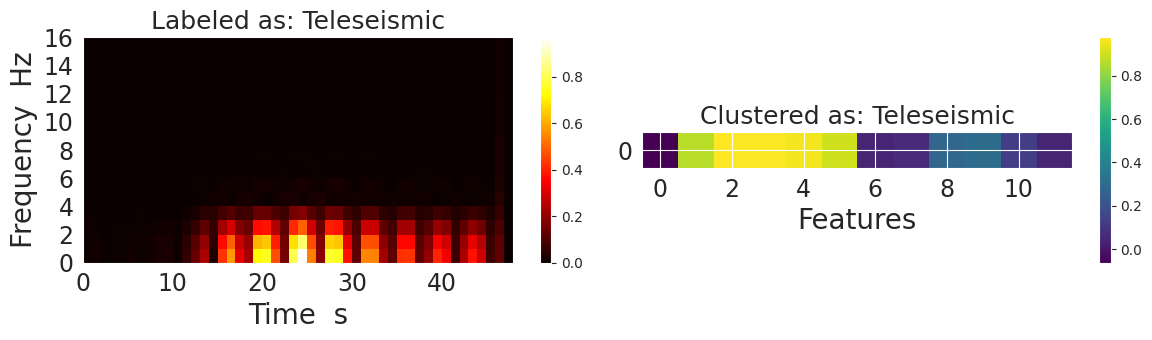

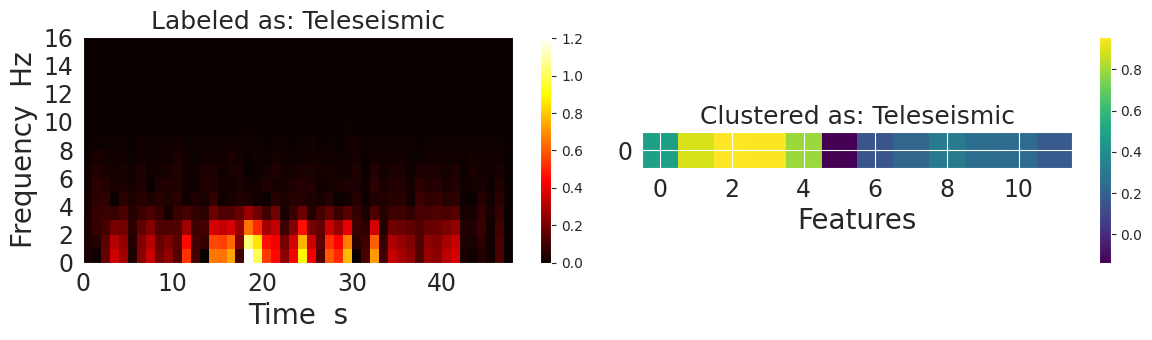

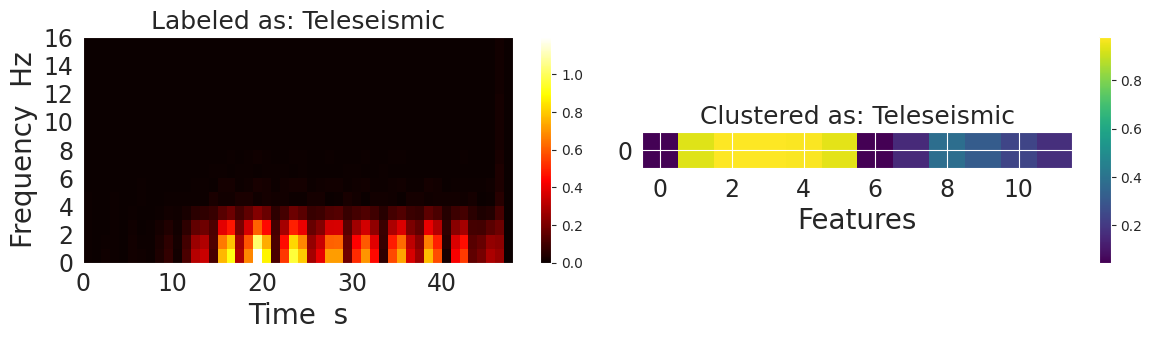

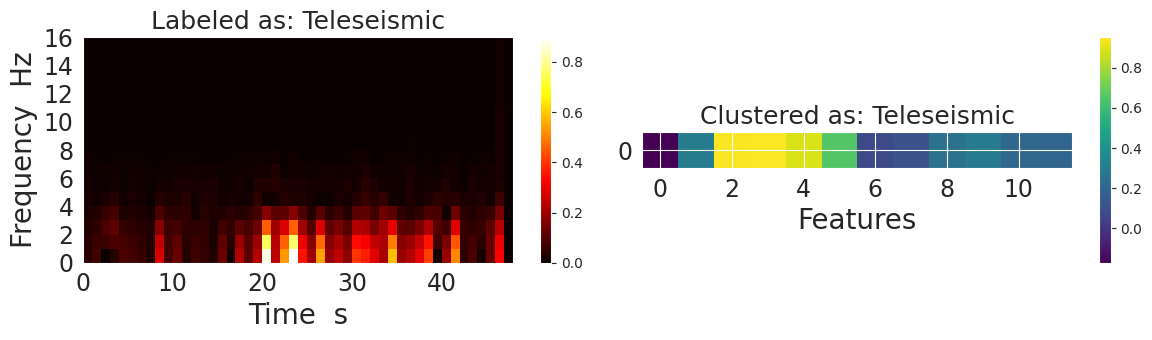

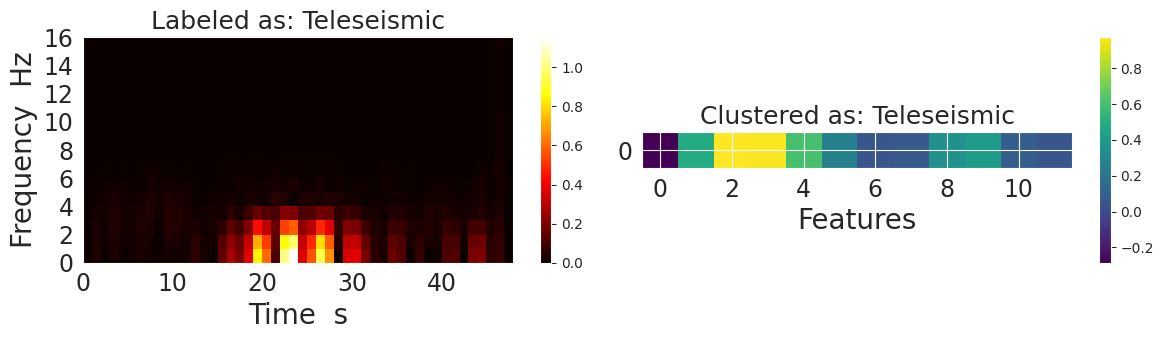

In [ ]:
q, _  = model.predict(x, verbose=0)
y_pred = q.argmax(1)
enc = encoder.predict(x)
# t = np.load('/content/T.npy')
# f = np.load('/content/D.npy')

for i in range(7000, 7010, 1):

    if y_pred[i] == 1. and y[i] == 1.:

        fig = plt.figure(figsize=(12, 3.5))
        ax = fig.add_subplot(121)
        plt.pcolormesh( x[i, :, :, 0], alpha=None, cmap='hot', shading='flat', antialiased=True)
        plt.ylabel('Frequency  Hz',  fontsize=20)
        plt.xlabel('Time  s', fontsize=20)
        plt.yticks(fontsize=17)
        plt.xticks(fontsize=17)
        plt.colorbar()

        if y[i] == 0.0:
            plt.title('Labeled as: Local', fontsize=18)
        else:
            plt.title('Labeled as: Teleseismic', fontsize=18)

        ax = fig.add_subplot(122)
        plt.imshow(enc[i].reshape(1, 12), cmap='viridis')
        plt.xlabel('Features', fontsize=20)
        plt.yticks(np.arange(0, 1, step=1), fontsize=17)
        plt.xticks(np.arange(0, 12, step=2), fontsize=17)
        plt.colorbar()

        if y_pred[i] == 0:
            plt.title('Clustered as: Local', fontsize=18)
        else:
            plt.title('Clustered as: Teleseismic', fontsize=18)
        fig.tight_layout()
        plt.show()

In [ ]:
print(y[7000:7010])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


288/288 [==============================] - 1s 4ms/step


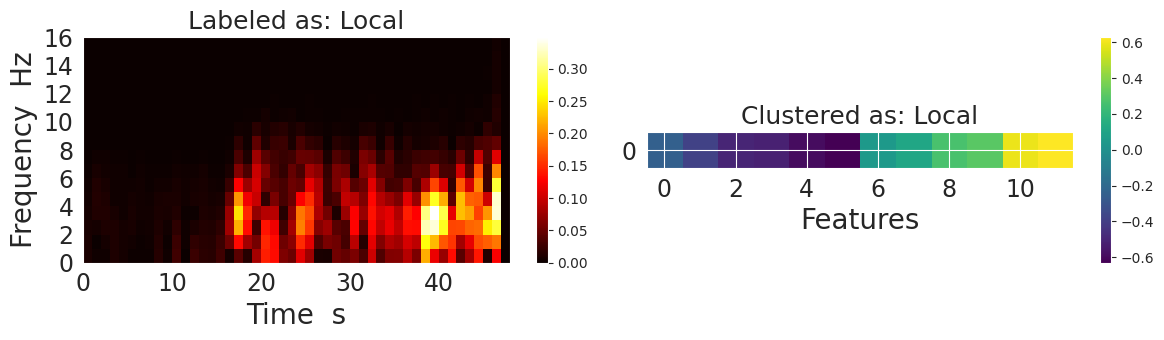

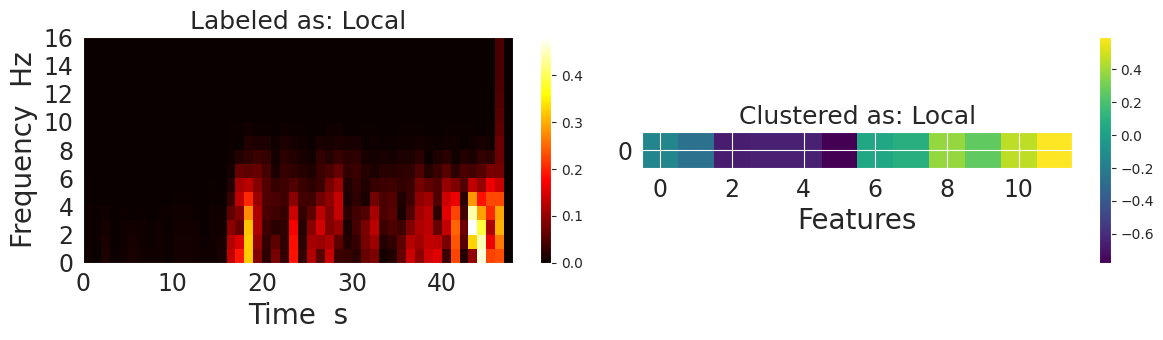

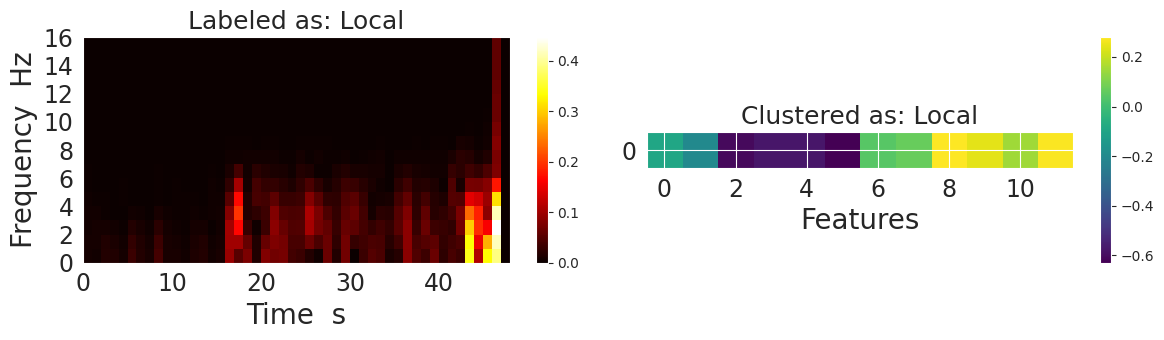

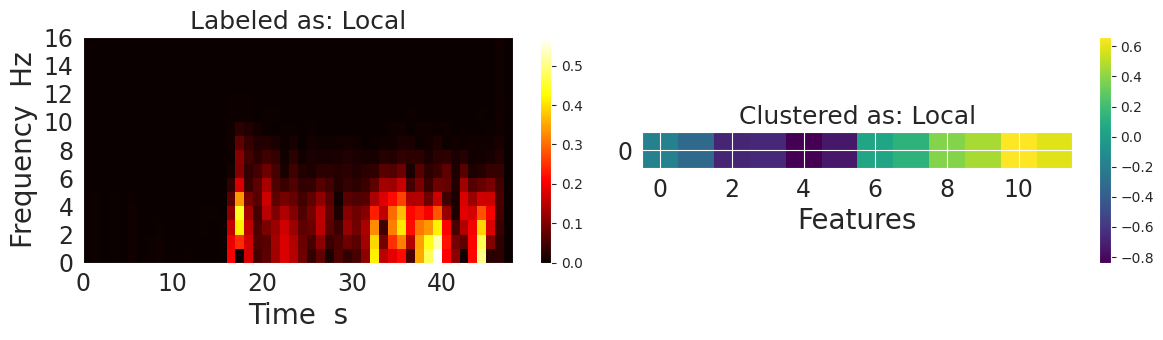

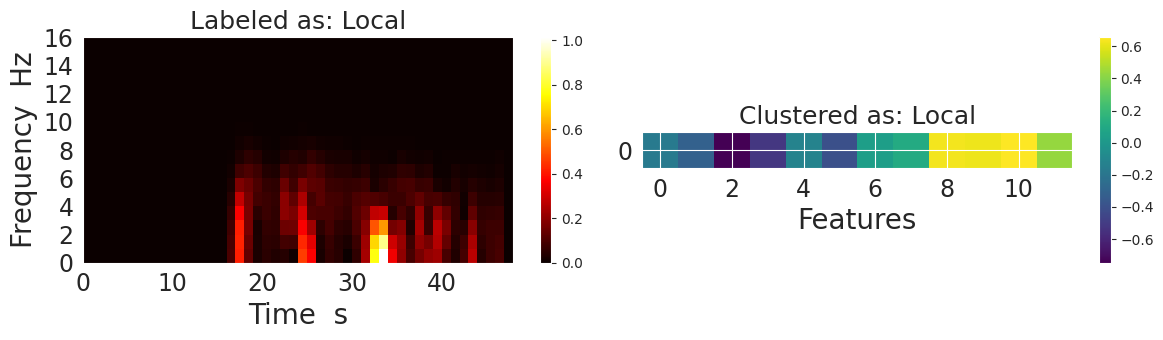

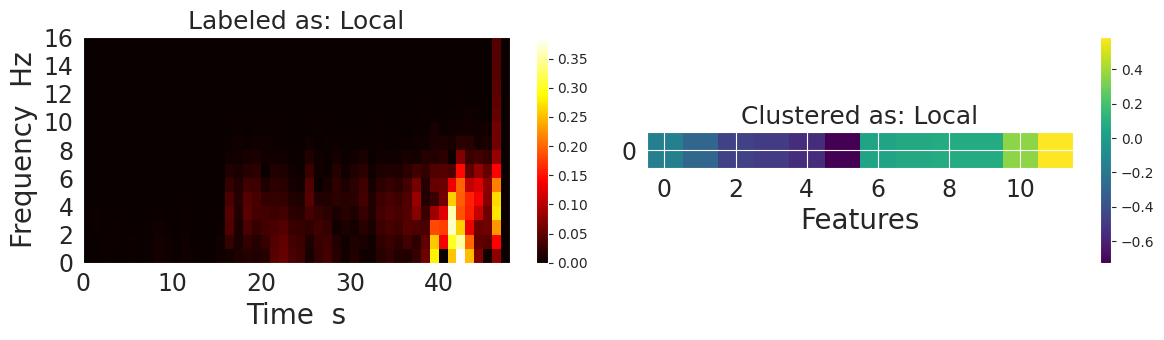

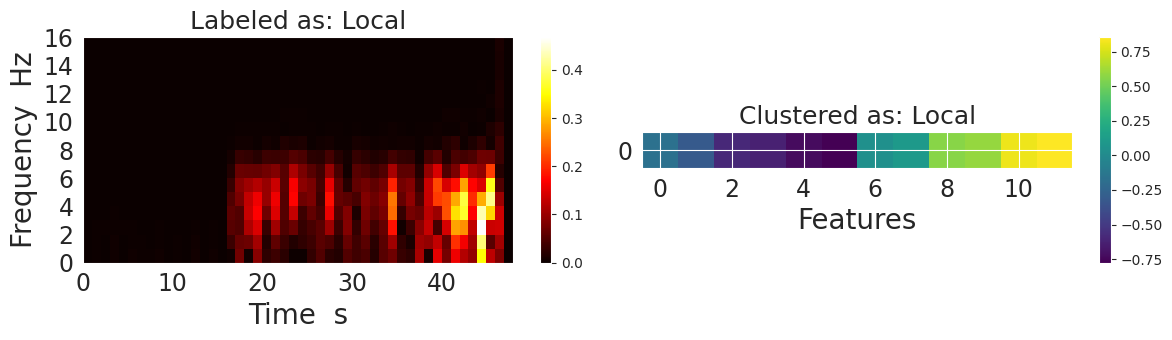

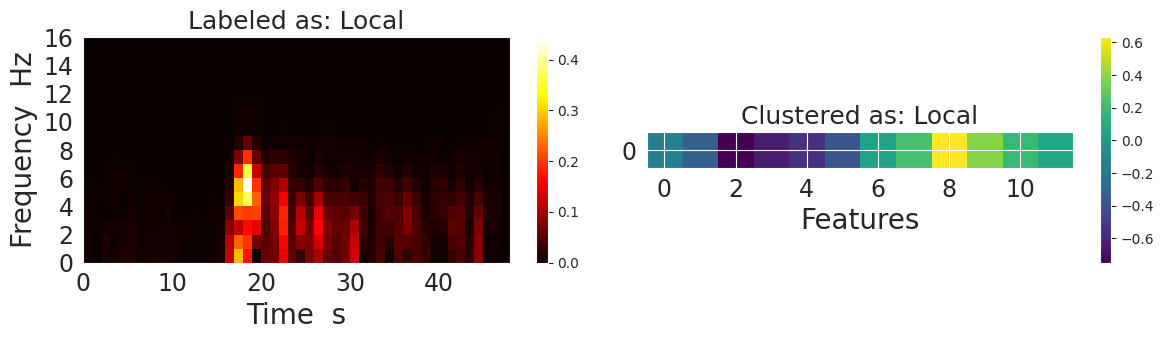

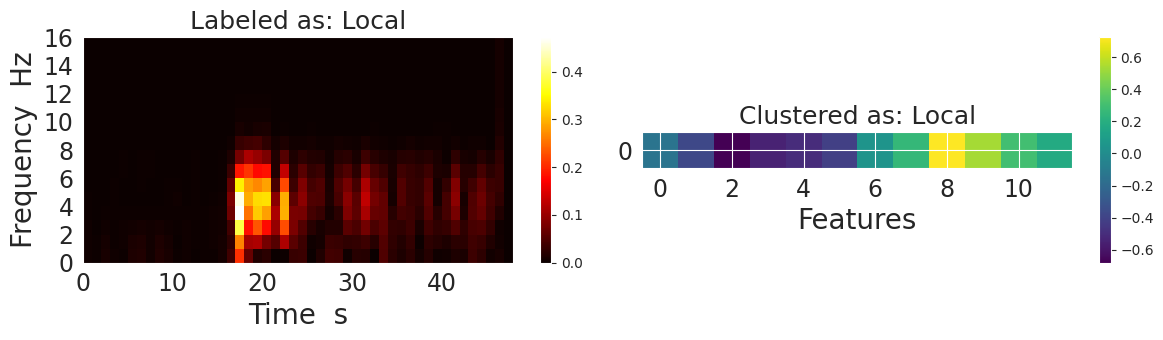

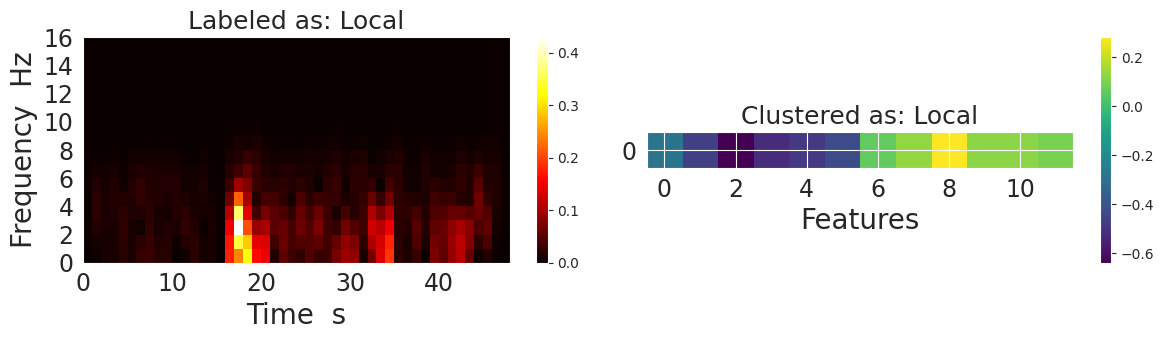

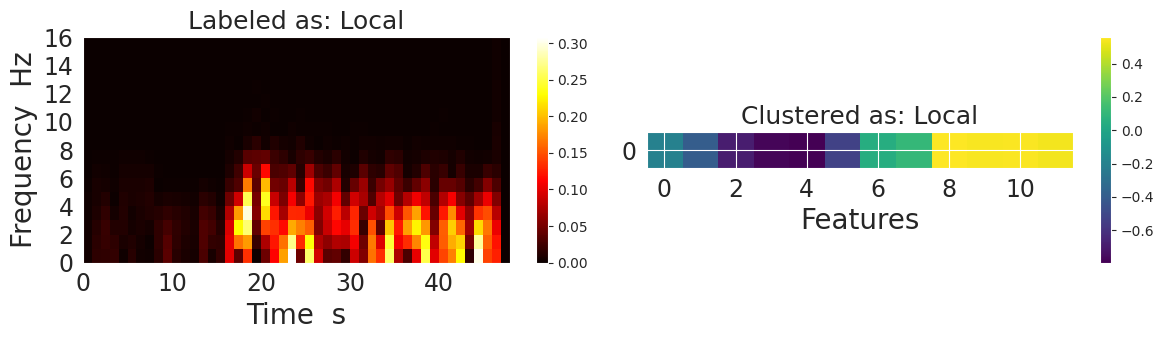

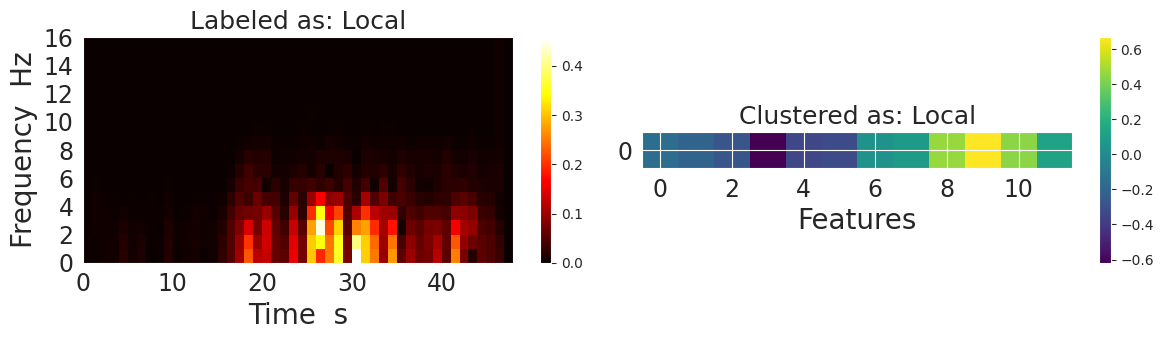

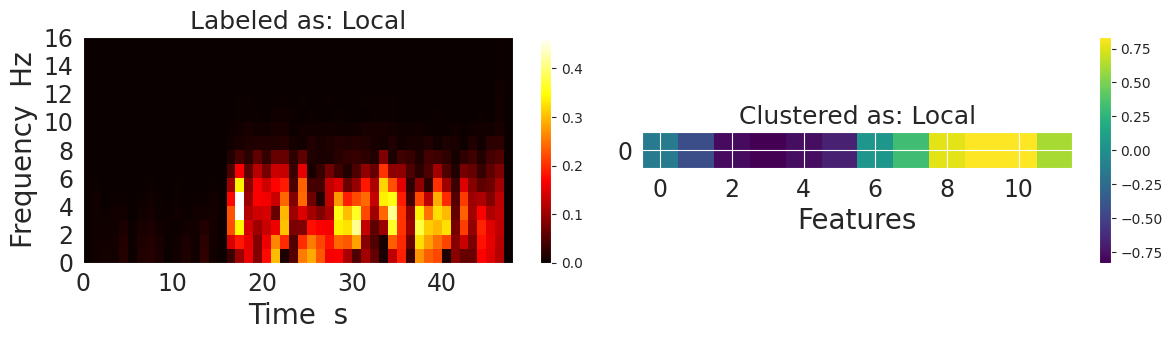

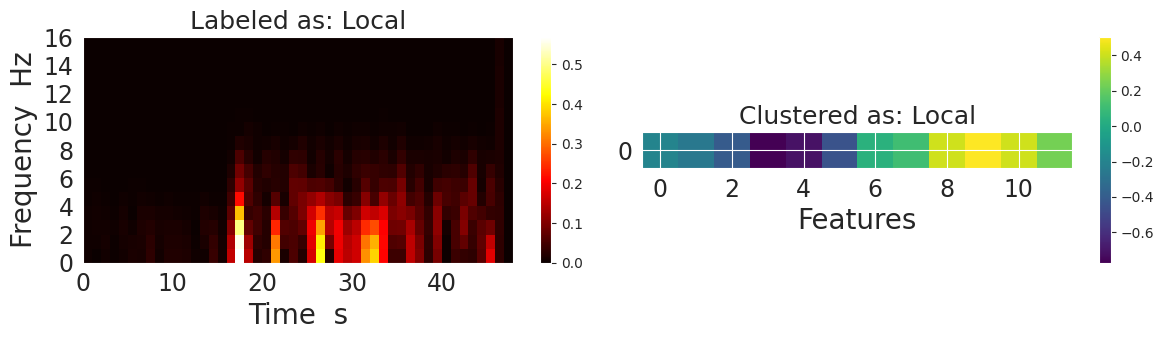

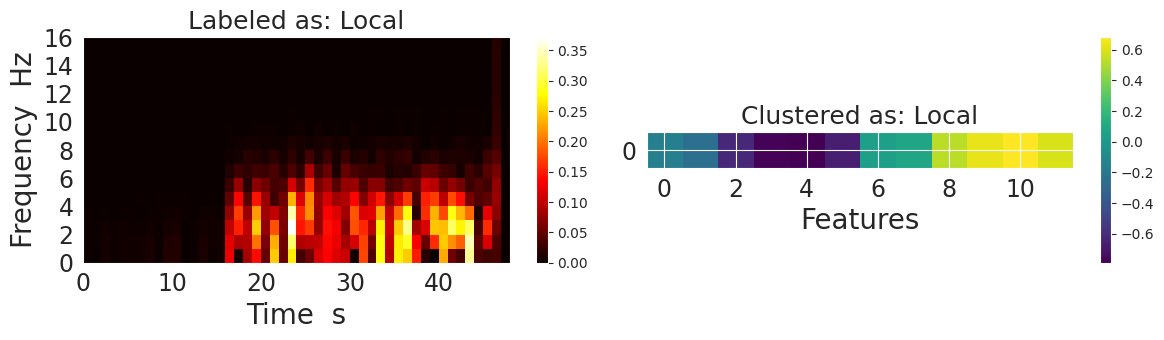

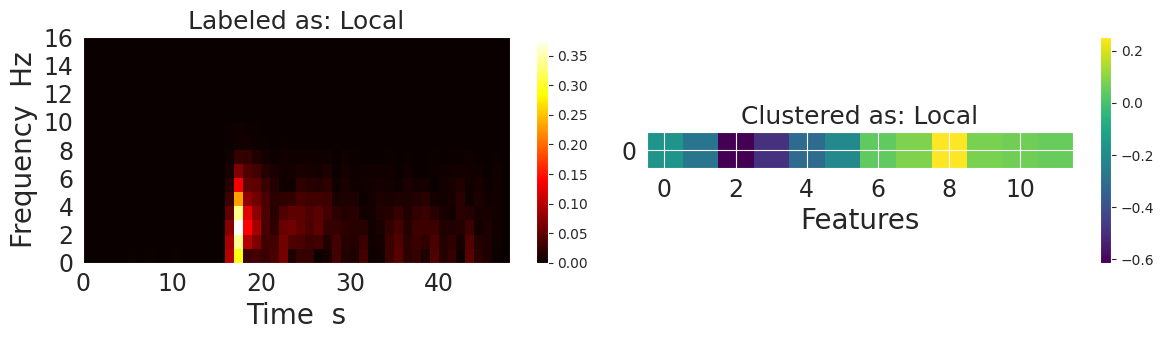

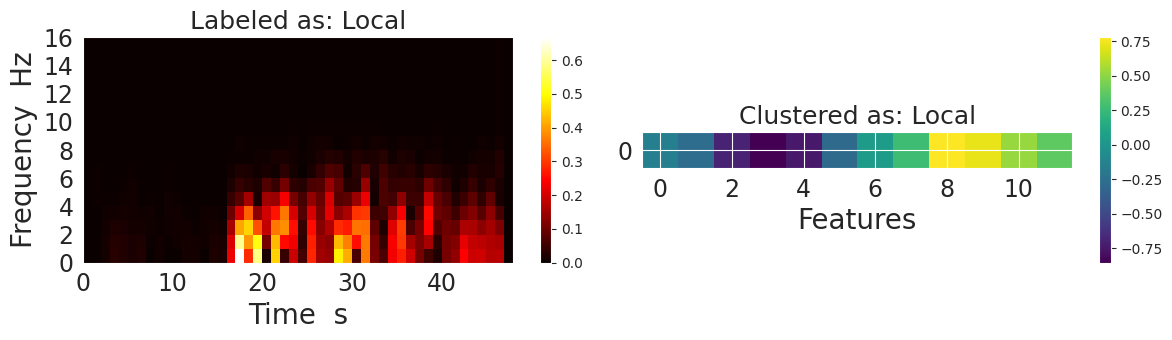

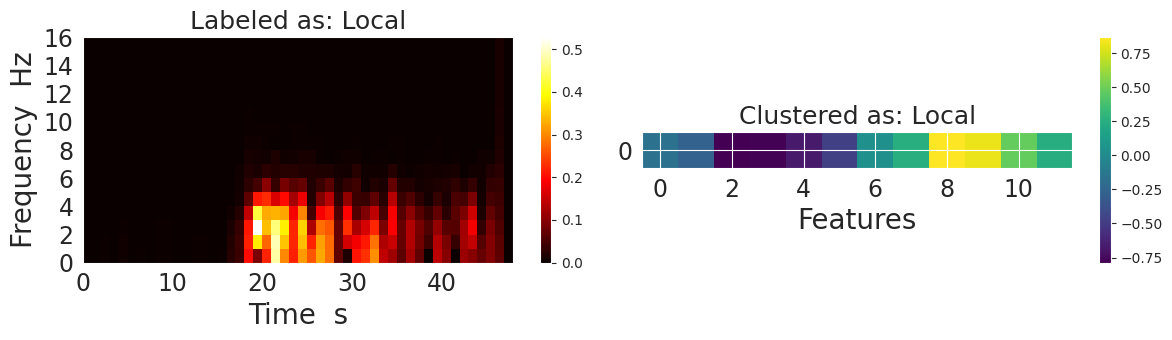

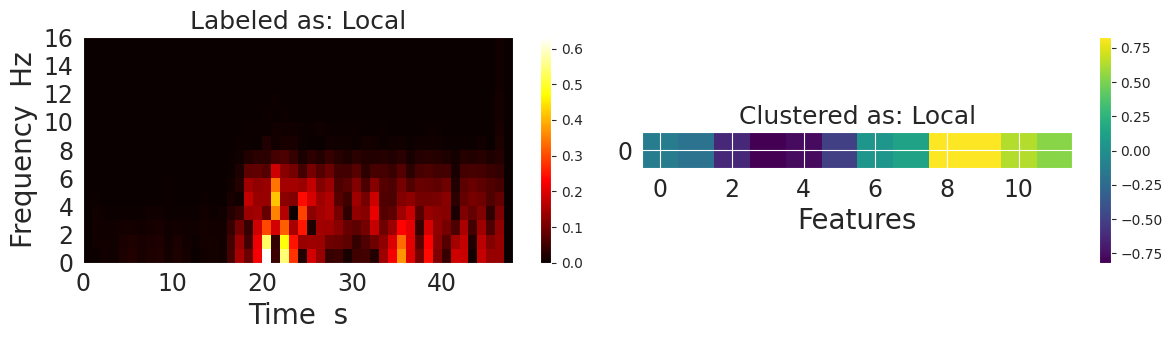

In [ ]:
q, _  = model.predict(x, verbose=0)
y_pred = q.argmax(1)
enc = encoder.predict(x)
# t = np.load('t.npy')
# f = np.load('f.npy')

for i in range(1, 20, 1):

    if y_pred[i] == 0. and y[i] == 0.:

        fig = plt.figure(figsize=(12, 3.5))
        ax = fig.add_subplot(121)
        plt.pcolormesh( x[i, :, :, 0], alpha=None, cmap='hot', shading='flat', antialiased=True)
        plt.ylabel('Frequency  Hz',  fontsize=20)
        plt.xlabel('Time  s', fontsize=20)
        plt.yticks(fontsize=17)
        plt.xticks(fontsize=17)
        plt.colorbar()

        if y[i] == 0.0:
            plt.title('Labeled as: Local', fontsize=18)
        else:
            plt.title('Labeled as: Teleseismic', fontsize=18)

        ax = fig.add_subplot(122)
        plt.imshow(enc[i].reshape(1, 12), cmap='viridis')
        plt.xlabel('Features', fontsize=20)
        plt.yticks(np.arange(0, 1, step=1), fontsize=17)
        plt.xticks(np.arange(0, 12, step=2), fontsize=17)
        plt.colorbar()

        if y_pred[i] == 0:
            plt.title('Clustered as: Local', fontsize=18)
        else:
            plt.title('Clustered as: Teleseismic', fontsize=18)
        fig.tight_layout()
        plt.show()

In [ ]:
print(y[1:20])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
